In [1]:
%load_ext autoreload
%autoreload 2

from environment.PendulumEnv import PendulumEnv, base_config
import torch
from utils.plotting import plot_training, plot_action_vs_angle
import numpy as np

torch.manual_seed(42)

# Introduction

## Problem definition

Our objective is to design a controller for the classic inverted pendulum (https://en.wikipedia.org/wiki/Inverted_pendulum) using reinforcement learning (RL) techniques. This system consists of a cart with a pendulum on top of it attached via a rotational joint. The cart can only move in one dimension and we are only allowed to apply a force onto the cart. The goal then is to stabilize the pendulum in the upright position.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Cart-pendulum.svg/1920px-Cart-pendulum.svg.png" style="background-color: white; width: 400px;"/>


## System model

Although the system we wish to control is governed by continuous-time dynamics (i.e. a differential equation in the form $\dot{x} = f(x)$), the control algorithm typically operates in discrete time. This justifies the following conceptual model for this problem.

$$
s_{t+1} = f(s_t, a_t)\\
r_t = r(s_t, a_t)
$$

where $s_t \in \mathcal{S}$ is the state of the system at time $t$ (here $\mathcal{S} = \mathbb{R}^4$), $a_t \in \mathcal{A}$ is the action (applied force) at time $t$ (here $\mathcal{A} = [-F_{max}, F_{max}]$) and $r_t \in \mathbb{R}$ is a scalar reward gained at timestep $t$. $f$ maps the current state $s_t$ and action $a_t$ into the next state $s_{t+1}$ and describes the discretized dynamics of the system. The reward function $r$ should in some way reflect our original objective - to stabilize the pendulum in the upright position.

Our goal is then to find a policy (a control rule / controller) $\pi : \mathcal{S} \rightarrow \mathcal{A}$, which maximizes the accumulated reward over interactions (episodes) with the system.

$$
\max_\pi \sum_{t=0}^{T-1} r_t
$$

where $T$ is the episode length.


## Environment

Reinforcement learning uses interactions with the system to learn a control policy maximizing the accumulated reward. Although it is possible to learn by interactions with the real physical system, it is common to train on a simulated version of it instead. This however means the applicability of the learned policy depends on how accurate the simulation is to the real system.

To implement the environment model, we will be using the mujoco (https://mujoco.org/) physical simulator. This simulator is given a simple model of the inverted pendulum described above and approximates the behavior of the real system using numerical integration.

The underlying simulator is wrapped in the `PendulumEnv` class. We start by copying the default configuration dictionary `base_config`. This dictionary contains the field `N` which sets the number of simulated pendulums in the environment. The `vis` field toggles rendering of the simulated environment.


In [2]:
# This controls the visualization of the environment, if you cannot view the environment or it is too slow on your machine, set this to False
VISUALIZE = True

In [3]:
print(base_config)

{'N': 2, 'vis': True}


In [4]:
base_config = {
    "N": 16,
    "vis": VISUALIZE,
}

The `PendulumEnv` constructor takes in the configuration dictionary and creates mujoco simulated environment in the background.


In [5]:
env = PendulumEnv(base_config)

Environment ready


The function `vector_reset()` is used to reset the internal simulation state to it's initial value and returns the initial state of system $s_0 \in \mathbb{R}^4$. To interact with the environment, we use the environment's `vector_step()` function. This function takes an array of actions $a_t \in [-1,1]$ (the actions are normalized for convenience), performs a simulation step $s_{t+1} = f(s_t, a_t)$ and returns the observed states $s_{t+1} \in \mathbb{R}^4$ and rewards $r_t \in \mathbb{R}$. The actions, states and rewards are all stored in arrays of length equal to the number of pendulums in the environment.

Learning a control policy using RL requires a large amount of interactions with the controlled environment. Simulating multiple pendulums inside one simulation instance allows doing this more efficiently.

Below is an example of environment interaction.


In [101]:
T = 512

s0 = env.vector_reset()
print('Returned state shape: ', np.array(s0).shape)

for i in range(T):
    actions = np.random.rand(base_config['N'], 1) * 2 - 1  # random actions sampled from [-1, 1]
    s, r = env.vector_step(actions)

env.close()

Returned state shape:  (16, 4)


# Policy gradient method

Though there are many approaches, which fall under the term reinforcement learning, we will focus on optimizing the policy directly. First, we need to construct a parametrized stochastic policy

$$
\pi_{\theta}(a_t | s_t)
$$

which maps the observed state $s_t$ into a probability distribution over the possible actions $a_t \in \mathcal{A}$. The policy parameters $\theta$ are what we are going to optimize over (think of them as neural network weights).

Let us denote the trajectory return (accumulated reward over a trajectory) as

$$
R(\tau) = \sum_{t=0}^{T-1} r_t
$$

where $\tau = (s_0, a_0, s_1, a_1, ... , s_{T-1}, a_{T-1}, s_{T})$ is a given trajectory. We then solve the following optimization task

$$
\theta = \arg \max_{\theta} \mathbb{E}_{\tau} \left[ R(\tau) \middle| \theta \right]
$$

using gradient ascent. The objective is simply the expected return of an episode conditioned on the policy parameters $\theta$

$$
\mathbb{E}_{\tau} \left[ R(\tau) \middle| \theta \right] = \int_\tau R(\tau) p(\tau | \theta)
$$

where $p(\tau | \theta)$ is the probability of trajectory $\tau$ conditioned on $\theta$. This has a simple intuitive interpretation: find the policy parameters $\theta$, such that the probability of trajectories with high return is maximized.

Even though the resulting policy will be used in deterministic manner, the probabilistic formulation is necessary for two reasons. The stochasticity allows us to explore the action space during training and it also allows us to compute the gradient of the objective.


## <font color='blue'> OPTIONAL READING </font>

## Deriving the policy gradient

The maximization objective is

$$
J = \int_\tau p(\tau | \theta) R(\tau) d\tau
$$

The probability of the trajectory is given by

$$
p(\tau | \theta) = p(s_0)\pi_\theta(a_0 | s_0)p(s_1 | s_0, a_0) ... p(s_{T-1} | s_{T-2}, a_{T-2})\pi_\theta(a_{T-1} | s_{T-1})p(s_{T}|s_{T-1}, a_{T-1})
$$

where $p(s_0)$ is the probability distribution of the initial state, $\pi_\theta$ is the policy and $p(s_{t+1} | s_t, a_t)$ here just represents the system dynamics. We assume the system dynamics to be deterministic and so the corresponding distribution is formally

$$
p(s_{t+1} | s_t, a_t) = \delta(s_{t+1} - f(s_t, a_t))
$$

i.e. zero everywhere except for the next state $f(s_t, a_t)$. In the general case, the integral in the objective function cannot be computed analytically (unless we assume, say, linear deterministic controller and quadratic reward function). Numerical integration would suffer from the curse of dimensionality, since the length of the episodes will be in the hundreds in our case (which would lead to integrating over hundreds of variables in $\tau$).
Luckily, we can get around this problem by applying the 'log trick' to the gradient of our objective

$$
\nabla_\theta J = \nabla_\theta \int_\tau p(\tau | \theta) R(\tau) d\tau = \int_\tau \nabla_\theta p(\tau | \theta) R(\tau) d\tau = \int_\tau p(\tau | \theta) \nabla_\theta \log (p(\tau | \theta)) R(\tau) d\tau
$$

where we used the fact that $\nabla_\theta \log(p(\tau | \theta)) =  \frac{\nabla_\theta p(\tau | \theta)}{p(\tau | \theta)}$. This enables us to <b>estimate the policy gradient</b> by sampling trajectories using current policy

$$
\nabla_\theta J \approx \hat{g} = \dfrac{1}{N} \sum_{i=1}^N \nabla_\theta \log (p(\tau_i | \theta)) R(\tau_i)
$$

where $\tau_i$ are the sampled trajectories. These trajectories $\tau_i$ are obtained by simply interacting with the environment while choosing actions according to the policy. To be clear, we are actually approximating the true trajectory distribution $p(\tau | \theta)$ using sampled trajectories as

$$
p(\tau | \theta) \approx \hat{p}(\tau | \theta) = \dfrac{1}{N} \sum_{i=1}^N \delta(\tau - \tau_i)
$$

Now we can use this 'policy gradient' for gradient ascent to iteratively improve our policy, hopefully increasing the expected accumulated reward.


## Simplifying the policy gradient

The formula for the approximated policy gradient can be further simplified by using the log-product rule

$$
\nabla_\theta J \approx \dfrac{1}{N} \sum_{i=1}^N \nabla_\theta \log (p(\tau_i | \theta)) R(\tau_i) \propto \dfrac{1}{N}\dfrac{1}{T} \sum_{i=1}^N R(\tau_i) \sum_{t=0}^{T-1} \nabla_\theta \log (\pi_\theta(a^i_t | s^i_t))
$$

where $s^i_t, a^i_t$ denote the state and action belonging to the $i$-th trajectory. Note that we also normalize the gradient by dividing with episode length $T$. So the finalized formula for policy gradient that we will use for policy training is

$$
\textcolor{red}{\hat{g} = \dfrac{1}{N}\dfrac{1}{T} \sum_{i=1}^N R(\tau_i) \sum_{t=0}^{T-1} \nabla_\theta \log (\pi_\theta(a^i_t | s^i_t))}
$$

This formula will be useful for your first task.

### Training algorithm

Now we can use this policy gradient approximation to train the policy according to the following pseudo-algorithm:

Given policy parameters $\theta_0$, and learning rate $\alpha > 0$
For k in range(iters):

1. Collect N trajectories $\{\tau_i \}_{i=1}^N$, while using the current policy parameters $\theta_k$ for action sampling.
2. For each trajectory, compute the return $R(\tau_i) = \sum_{t=0}^{T-1} r^i_t$
3. Compute the policy gradient approximation $\hat{g}$ using the returns and log-probabilities
4. Update the policy $\theta_{k+1} = \theta_{k} + \alpha \hat{g}$

Note: when using autodiff engine such as pytorch, we need to compute the <b>loss</b> instead of the policy gradient.


## Policy

We talked about how we can train a stochastic policy $\pi_\theta(a_t | s_t)$, but how do we actually implement it? Since this is a deep learning course, our policy will be represented by a neural network. The neural network $n_{\theta}(s_t)$ is however a deterministic mapping on its own. A common way to solve this is to create the distribution from the neural network outputs. But this must be done, so that we can back-propagate through this distribution afterward.

One possible solution is to make the network output mean and standard deviation $(\mu_\theta(s_t), \sigma_\theta(s_t))$ of a normal distribution. The actions are then sampled from the resulting normal distribution

$$
a_t \sim N(\mu_\theta(s_t), \sigma_\theta(s_t))
$$

And in this way, we have created the parametrized stochastic policy that we will train!

$$
\pi_\theta(a_t | s_t) = N(\mu_\theta(s_t), \sigma_\theta(s_t))
$$


# Implementation

## Policy

We start by implementing our parametrized stochastic policy using pytorch. This part is already done below in the form of `StochasticPolicy` class. It initializes a neural network that maps from the state space $\mathbb{S} = \mathbb{R}^4$ into the normal distribution mean and standard deviation $\mu, \sigma$ as described above.

The `determine_actions()` function returns only the mean $\mu$ obtained computed by the neural network and can be used to sample deterministic actions.

The `sample_actions()` function implements sampling from the normal distribution constructed from the network outputs and can be used during training for action space exploration.

The `log_prob()` function returns the logarithm of action probabilities $\log ( \pi_\theta(a_t | s_t) )$ given the observed states. This can be used for computing the policy gradient approximation for training.


In [6]:
from torch import nn
from torch.distributions.normal import Normal


class StochasticPolicy(nn.Module):

    def __init__(self, state_dim=4, action_dim=1):
        super(StochasticPolicy, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2 * action_dim),
        )

    def determine_actions(self, states):
        """states is (N, state_dim) tensor, returns (N, action_dim) actions tensor. 
        This function returns deterministic actions based on the input states. This would be used for control. """
        params = self.network(states)  # map states to distribution parameters
        mu, _ = torch.chunk(params, 2, -1)  # split the parameters into mean and std, return mean
        return mu

    def sample_actions(self, states):
        """states is (T, N, state_dim) tensor, returns (T, N, action_dim) actions tensor. 
        This function returns probabilistically sampled actions. This would be used for training the policy."""
        params = self.network(states)  # map states to distribution parameters
        mu, sigma = torch.chunk(params, 2, -1)  # split the parameters into mean and std
        sigma = torch.nn.functional.softplus(sigma)  # make sure std is positive
        distribution = Normal(mu, sigma)  # create distribution of size (T, N, action_dim)
        actions = distribution.sample()  # sample actions
        return actions

    def log_prob(self, actions, states):
        """states is (T, N, state_dim) tensor. actions is (T, N, action_dim) tensor.
        This function returns the log-probabilities of the actions given the states. $\log \pi_\theta(a_t | s_t)$"""
        params = self.network(states)  # map states to distribution parameters
        mu, sigma = torch.chunk(params, 2, -1)  # split the parameters into mean and std
        sigma = torch.nn.functional.softplus(sigma)  # make sure std is positive
        distribution = Normal(mu, sigma)  # create distribution of size (T, N, action_dim)
        logp = distribution.log_prob(actions)
        if len(logp.shape) == 3 and logp.shape[2] > 1:  # this allows generalization to multi-dim action spaces
            logp = logp.sum(dim=2, keepdim=True)  # sum over the action dimension
        return logp

<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
/var/folders/26/ht400cyn525fbdn9bmxl6cn00000gn/T/ipykernel_49036/3303015818.py:36: SyntaxWarning: invalid escape sequence '\l'
  """states is (T, N, state_dim) tensor. actions is (T, N, action_dim) tensor.


Policy controlling the environment example.


In [7]:
def test_policy(pi, T=128, config=base_config, deterministic=True):
    test_env = PendulumEnv(config)
    mean_reward = 0

    s = test_env.vector_reset()
    for i in range(T):
        with torch.no_grad():
            if deterministic:
                actions = pi.determine_actions(torch.tensor(s).float())  # use deterministic actions based on the states
            else:
                actions = pi.sample_actions(torch.tensor(s).float())  # use random actions conditioned on the states
        s, r = test_env.vector_step(actions.numpy())
        mean_reward += sum(r) / (T * config['N'])

    test_env.close()
    return mean_reward

In [8]:
config = {'N': 64, 'vis': VISUALIZE}

pi = StochasticPolicy(state_dim=4)

test_policy(pi, 256, config, deterministic=True)

Environment ready


/var/folders/26/ht400cyn525fbdn9bmxl6cn00000gn/T/ipykernel_49036/2430633286.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  actions = pi.determine_actions(torch.tensor(s).float())  # use deterministic actions based on the states
2024-12-31 00:17:48.527 Python[49036:7247393] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-31 00:17:48.527 Python[49036:7247393] +[IMKInputSession subclass]: chose IMKInputSession_Modern


-0.35537166094173167

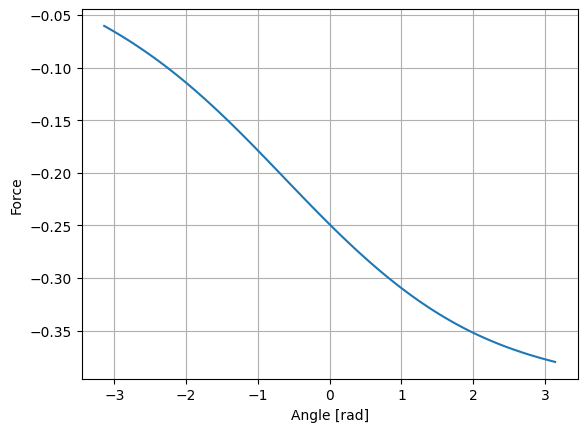

In [9]:
plot_action_vs_angle(pi)

## Task 1) Simple policy gradient


In [52]:
# TODO: complete the implementation in solution.py
from solution import policy_gradient_loss_simple

Quick test for your implementation is below. The output should be: tensor(1.)


In [59]:
test_r = torch.tensor([1, 2, 1, 0, 1, 1, 0, 2]).reshape((8, 1)).float()  # testing rewards
test_logp = torch.tensor([0, -3, 0, -1, -2, 3, 1, 1]).reshape((8, 1)).float()  # testing logp

assert torch.allclose(policy_gradient_loss_simple(test_logp, test_r), torch.Tensor([1.]), atol=1e-4), "incorrect output"

/Users/hella/Desktop/hw5-rl/solution.py:26: SyntaxWarning: invalid escape sequence '\s'
  Given the rewards and the discount factor gamma, compute the discounted cumulative sum of rewards.


Helper function for collecting trajectories.


In [60]:
def sample_trajectories(env, pi, T):
    """given an environment env, a stochastic policy pi and number of timesteps T, interact with the environment for T steps 
    using actions sampled from policy. Return torch tensors of collected states, actions and rewards"""
    states = np.zeros((T + 1, N, env.num_states), dtype=float)  # states from s(0) to s(T+1)
    actions = np.zeros((T, N, env.num_actions), dtype=float)  # actions from a(0) to a(T)
    rewards = np.zeros((T, N), dtype=float)  # rewards from r(0) to r(T)

    s = env.vector_reset()
    states[0] = s
    for t in range(T):
        a = pi.sample_actions(torch.tensor(states[t]).float())  # policy needs float torch tensor (N, state_dim)
        s_next, r = env.vector_step(np.array(a))  # env needs numpy array of (Nx1)
        states[t + 1], actions[t], rewards[t] = s_next, a, r

    tensor_s = torch.tensor(states).float()  # (T+1, N, state_dim)  care for the extra timestep at the end!
    tensor_a = torch.tensor(actions).float()  # (T, N, 1)
    tensor_r = torch.tensor(rewards).float()  # (T, N)

    return tensor_s, tensor_a, tensor_r

Time to train the policy!


Environment ready
Epoch 0, mean reward: 0.010
Epoch 10, mean reward: -0.018
Epoch 20, mean reward: 0.118
Epoch 30, mean reward: 0.210
Epoch 40, mean reward: 0.380
Epoch 50, mean reward: 0.510
Epoch 60, mean reward: 0.417
Epoch 70, mean reward: 0.398
Epoch 80, mean reward: 0.348
Epoch 90, mean reward: 0.458


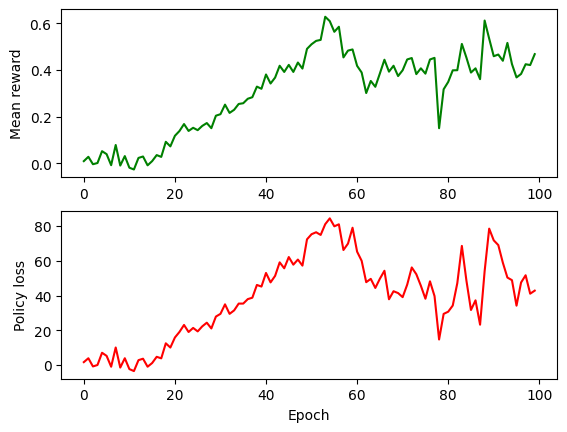

In [68]:
# training parameters
N = 32
T = 128
config = {'N': N, 'vis': False}
epochs = 100
lr = 0.01

# policy, environment and optimizer
pi = StochasticPolicy(state_dim=4)
train_env = PendulumEnv(config)
optim = torch.optim.SGD(pi.parameters(), lr=lr)

mean_rewards, p_losses = np.zeros(epochs), np.zeros(epochs)  # for logging mean rewards over epochs
for epoch in range(epochs):
    tensor_s, tensor_a, tensor_r = sample_trajectories(train_env, pi, T)  # collect trajectories using current policy

    logp = pi.log_prob(tensor_a, tensor_s[:T]).squeeze(2)  # compute log(pi(a_t | s_t))
    loss = policy_gradient_loss_simple(logp, tensor_r)  # compute the policy gradient loss

    optim.zero_grad()
    loss.backward()  # backprop and gradient step
    optim.step()

    if epoch % 10 == 0:
        print('Epoch %d, mean reward: %.3f' % (epoch, tensor_r.mean()))
    mean_rewards[epoch] = tensor_r.mean()
    p_losses[epoch] = loss.item()

train_env.close()

plot_training(mean_rewards, p_losses)

In [69]:
test_policy(pi, 256, {'N': 16, 'vis': VISUALIZE})

Environment ready


0.10872760750143584

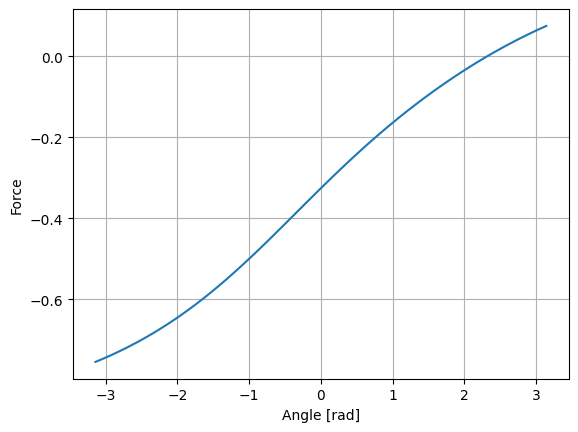

In [70]:
plot_action_vs_angle(pi)

## Task 2) Discounted policy gradient


## Reducing variance of the gradient

As it turns out, using simple trajectory returns for policy gradient computation has quite poor performance. The policy gradient formula we derived is

$$
\hat{g} = \dfrac{1}{N}\dfrac{1}{T} \sum_{i=1}^N R(\tau_i) \sum_{t=0}^{T-1} \nabla_\theta \log (\pi_\theta(a^i_t | s^i_t))
$$

which uses the trajectory return $R(\tau_i) = \sum_{t=0}^{T-1}r^i_t$ to weight each trajectory's contribution to the overall gradient. It however only differentiates between better and worse trajectories, but does not take into account the influence of individual actions. This leads to the gradient estimate having high variance, which makes training unstable. We would instead like to reinforce only the actions which are directly responsible for the increase in reward. Determining which actions and to what extent are responsible for the obtained reward is known as the credit assignment problem.

To reduce the variance of the policy gradient estimate, we introduce a discount factor $\gamma \in (0,1)$, which reduces the influence of rewards that are far in the future. We also reformulate the return to account for infinite time horizon, which is more mathematically convenient. The return of the trajectory is then computed as

$$
R(\tau) = \sum_{t=0}^{\infty} \gamma^{t} r_t
$$

Note that while the variance of the estimate is decreased, we introduce bias (the expected value of the gradient estimate $\hat{g}$ is no longer equal to the policy gradient $\nabla_\theta J$). For the discount factor to make sense, this return should be computed for each timestep individually. This makes sure that the exponential decay starts at the reward corresponding to the current timestep. To be clear, the gradient estimate implementation with the discounted return becomes

$$
\textcolor{red}{
\hat{g} = \dfrac{1}{N}\dfrac{1}{T} \sum_{i=1}^N \sum_{t=0}^{T-1} \left( \sum_{t'=t}^{T-1} \gamma^{t'-t} r_{t'} \right)\nabla_\theta \log (\pi_\theta(a^i_t | s^i_t))
}
$$


In [71]:
# TODO: complete the implementation of policy_gradient_loss_discounted() and discount_cum_sum() in solution.py
from solution import policy_gradient_loss_discounted

/Users/hella/Desktop/hw5-rl/solution.py:25: SyntaxWarning: invalid escape sequence '\s'
  """


Quick test for your implementation is below. The output should be: tensor(1.7653)


In [76]:
test_r = torch.tensor([1, 2, 1, 0, 1, 1, 0, 2]).reshape((8, 1)).float()  # testing rewards
test_logp = torch.tensor([0, -3, 0, -1, -2, 3, 1, 1]).reshape((8, 1)).float()  # testing logp
test_gamma = 0.9

assert torch.allclose(policy_gradient_loss_discounted(test_logp, test_r, test_gamma), torch.Tensor([1.7653]), atol=1e-4), "incorrect output"

/Users/hella/Desktop/hw5-rl/solution.py:25: SyntaxWarning: invalid escape sequence '\s'
  """


Environment ready
Epoch 0, mean reward: 0.038
Epoch 10, mean reward: 0.089
Epoch 20, mean reward: 0.223
Epoch 30, mean reward: 0.247
Epoch 40, mean reward: 0.291
Epoch 50, mean reward: 0.402
Epoch 60, mean reward: 0.440
Epoch 70, mean reward: 0.404
Epoch 80, mean reward: 0.495
Epoch 90, mean reward: 0.625


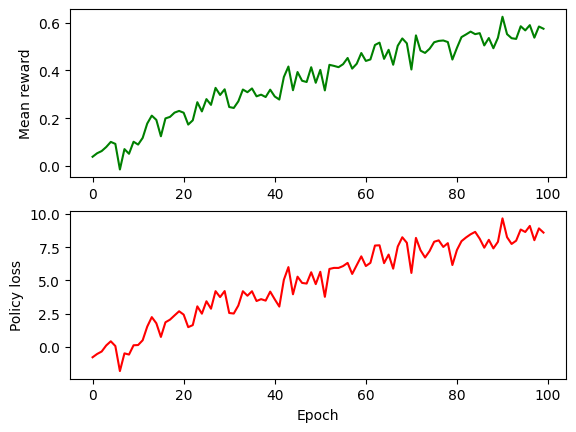

In [113]:
# training parameters
N = 32
T = 128
config = {'N': N, 'vis': 0}
epochs = 100
lr = 0.01
gamma = 0.95

# policy, environment and optimizer
pi = StochasticPolicy(state_dim=4)
train_env = PendulumEnv(config)
optim = torch.optim.SGD(pi.parameters(), lr=lr)

mean_rewards, p_losses = np.zeros(epochs), np.zeros(epochs)
for epoch in range(epochs):
    tensor_s, tensor_a, tensor_r = sample_trajectories(train_env, pi, T)  # collect trajectories using current policy

    logp = pi.log_prob(tensor_a, tensor_s[:T]).squeeze(2)  # compute log(pi(a_t | s_t))
    loss = policy_gradient_loss_discounted(logp, tensor_r, gamma)  # compute the policy gradient loss

    optim.zero_grad()
    loss.backward()  # backprop and gradient step
    optim.step()

    if epoch % 10 == 0:
        print('Epoch %d, mean reward: %.3f' % (epoch, tensor_r.mean()))
    mean_rewards[epoch] = tensor_r.mean()
    p_losses[epoch] = loss.item()

train_env.close()

plot_training(mean_rewards, p_losses)

In [114]:
test_policy(pi, 256, {'N': 16, 'vis': VISUALIZE})

Environment ready


0.9741506506834412

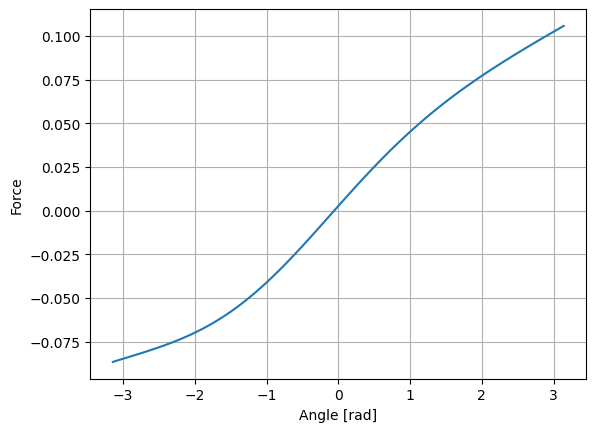

In [115]:
plot_action_vs_angle(pi)

# Task 3) policy gradient estimate using advantage

To further reduce variance of the estimate, we replace the discounted returns $R(\tau)$ with so-called advantage function.

$$
A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s)
$$

where $V$ and $Q$ are called value function and action-value function respectively. Formally,

$$
V^{\pi}(s) = \mathbb{E}_{\tau} \left[ \sum_{t=0}^{\infty} \gamma^{t} r_t \middle| s_0 = s \right] \\
Q^{\pi}(s,a) = \mathbb{E}_{\tau} \left[ \sum_{t=0}^{\infty} \gamma^{t} r_t \middle| s_0 = s, a_0 = a \right]
$$

Informally, the value function is the expected return of a trajectory starting in a given state $s$, while following the policy $\pi$. The action-value function is the same thing, except it assumes we take the specific action $a$ from state $s$ and follow the policy onward. The advantage function $A^{\pi}(s,a)$ then expresses, how the expected return improves, if we take the given action $a$ as compared to following the policy.
If the advantage for a given action is positive, it means that taking the given action $a$ increases the expected return compared to the current policy, and so we should increase its probability. The only problem is that this advantage function is unknown to us, and so we have to estimate it. This makes the training a little more complicated, but pays off in reduced gradient estimate variance.

### Advantage estimation overview

Advantage function estimation is beyond the scope of this assignment, and so we will only go over the basic idea. First, we construct a value network

$$
\hat{V}_\theta : \mathcal{S} \rightarrow \mathbb{R}
$$

that serves to approximates the true value function $V^{\pi}(s)$. The $\theta$ denotes the learnable parameters, which are usually shared with the policy network. The value function is easier to approximate than the advantage function, since it is only a function of the state. The advantage estimates $\hat{A}(s, a)$ are then be computed using the value network outputs and collected rewards.

This value network is trained in parallel with the policy to regress value targets $V^*(s)$, which are estimated from the trajectory rewards. This is typically done by minimizing the L2 distance between the value network and the value targets

$$
\textcolor{red}{
L_v(\theta) = \dfrac{1}{N}\dfrac{1}{T} \sum_{i=1}^N \sum_{t=0}^{T-1}  \left( \hat{V}_\theta(s_t^i) - V^*(s_t^i)\right)^2
}
$$

using gradient descent. The advantage estimation and value target computation is already implemented below.

The resulting policy gradient estimate using the estimated advantages is then

$$
\textcolor{red}{
\hat{g} = \dfrac{1}{N}\dfrac{1}{T} \sum_{i=1}^N \sum_{t=0}^{T-1} \hat{A}(s_t^i, a_t^i)\nabla_\theta \log (\pi_\theta(a^i_t | s^i_t))
}
$$

where $\hat{A}(s, a)$ is the advantage estimate for given state $s$ and action $a$. Even though the advantage estimates are also a function of the network parameters $\theta$, we consider them to be constant when computing the policy gradient.


## <font color='blue'> OPTIONAL READING </font>

### Advantage estimation implementation

The function `compute_advantage_estimates()` is given a tensor of collected rewards and estimated values on sampled trajectories together with the discount factor $\gamma$. It then computes the value function targets and advantage estimates. The value targets will be used to train our value function network and the advantage estimates will be used to estimate the policy gradient. Note that it uses the function `discount_cum_sum()`.

While it is not a part of the assignment, we can briefly summarize, what the function does.

If `bootstrap` is disabled, it simply uses the discounted return as the value function target, which is consistent with the finite horizon formulation of trajectory return. This leads to a problem: the value targets near the start of the trajectory will have more terms in the return sum than those at the end. This means the range of possible value targets is larger at the start of the trajectory than at the end. This can in turn lead to convergence problems.

If `bootstrap` is enabled, it appends the estimated values at the end of the trajectory (at time $T$) to the rewards and then computes the discounted returns, which is consistent with the infinite horizon formulation. The last value target in this scenario would be $V^*(s_T) =  r_{T-1} + \gamma \hat{V}(s_T)$. If our value estimate $\hat{V}$ is good (accurate), this will mitigate the problem that arises without bootstrapping. If the value estimate is bad (inaccurate), we introduce a source of noise into the value function training.

Irrelevant of how we acquire the value targets, the advantage estimates are computed as

$$
\hat{A}^\pi(s_t,a_t) = V^*(s_t) - \hat{V}(s_t)
$$

where $V^*(s_t)$ is the value target at state $s_t$ and $\hat{V}(s_t)$ is the value estimate at $s_t$. Note that we do not model the $Q$ function explicitly. Instead, the value target $V^*(s_t)$ can be considered a $Q$ function estimate, since it depends on which action we took from state $s_t$. We call it the value target, because we use it for the value network training.

The function `compute_gae()` implements a more advanced version of the advantage estimation algorithm based on the paper https://arxiv.org/abs/1506.02438. In addition to the rewards, values and discount factor $\gamma$, it accepts another hyperparameter $\lambda \in [0, 1]$, which controls the trade-off between bias and variance of the advantage estimate. For $\lambda = 1$, the function is equivalent to the `compute_advantage_estimates()` function with bootstrapping enabled. Feel free to experiment with different settings.


In [83]:
from solution import discount_cum_sum


def compute_advantage_estimates(tensor_r, values, gamma, bootstrap=False):
    """given reward tensor (T, N), value estimates tensor (T+1, N) and gamma scalar"""
    if bootstrap:  # use last value estimates as a return estimate
        terminal_value_estimates = values[-1].unsqueeze(0)  # values of the last states (1, N)
        rs_v = torch.cat((tensor_r, terminal_value_estimates), dim=0)
        value_targets = discount_cum_sum(rs_v, gamma)[:-1]
    else:
        value_targets = discount_cum_sum(tensor_r, gamma)
    advantages = value_targets - values[:-1]
    return value_targets, advantages


def compute_gae(tensor_r, values, gamma, lambda_):
    """generalized advantage estimation (GAE) implementation"""
    delta_t = tensor_r + gamma * values[1:] - values[:-1]
    advantages = discount_cum_sum(delta_t, gamma * lambda_)
    value_targets = advantages + values[:-1]
    return value_targets, advantages

## Stochastic policy with value function

Below is an implementation of a stochastic policy together with value network in the form of the `StochasticPolicyValue` class. The policy has shared layers that are used to compute features for the action and value networks. This can be thought of as a way to share information between the two networks and can improve the performance.

The `determine_actions()`, `sample_actions()` and `log_prob()` functions work the same way as in the previously used `StochasticPolicy`.

The additional `value_estimates()` function is used to estimate the value function on given states.


In [84]:
class StochasticPolicyValue(nn.Module):
    def __init__(self, state_dim=4, action_dim=1):
        super(StochasticPolicyValue, self).__init__()

        # shared layers between the action and value heads
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.Tanh(),
        )

        # action head
        self.action_layers = nn.Sequential(
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2 * action_dim),
        )

        # value head
        self.value_layers = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def determine_actions(self, states):
        """states is (N, state_dim) tensor, returns (N, action_dim) actions tensor. 
        This function returns deterministic actions based on the input states. This would be used for control. """
        params = self.action_layers(self.shared_layers(states))  # map states to distribution parameters
        mu, _ = torch.chunk(params, 2, -1)  # split the parameters into mean and std, return mean
        return mu

    def sample_actions(self, states):
        """states is (T, N, state_dim) tensor, returns (T, N, action_dim) actions tensor. 
        This function returns probabilistically sampled actions. This would be used for training the policy."""
        params = self.action_layers(self.shared_layers(states))  # map states to distribution parameters
        mu, sigma = torch.chunk(params, 2, -1)  # split the parameters into mean and std
        sigma = torch.nn.functional.softplus(sigma)  # make sure std is positive
        distribution = Normal(mu, sigma)  # create distribution of size (T, N, action_dim)
        actions = distribution.sample()  # sample actions
        return actions

    def log_prob(self, actions, states):
        """states is (T, N, state_dim) tensor. actions is (T, N, action_dim) tensor.
        This function returns the log-probabilities of the actions given the states. $\log \pi_\theta(a_t | s_t)$"""
        params = self.action_layers(self.shared_layers(states))  # map states to distribution parameters
        mu, sigma = torch.chunk(params, 2, -1)  # split the parameters into mean and std
        sigma = torch.nn.functional.softplus(sigma)  # make sure std is positive
        distribution = Normal(mu, sigma)  # create distribution of size (T, N, action_dim)
        logp = distribution.log_prob(actions)
        if len(logp.shape) == 3 and logp.shape[2] > 1:  # this allows generalization to multi-dim action spaces
            logp = logp.sum(dim=2, keepdim=True)  # sum over the action dimension
        return logp

    def value_estimates(self, states):
        """states is (T, N, state_dim) tensor, returns (T, N) values tensor. Useful for value estimation during training."""
        return self.value_layers(self.shared_layers(states)).squeeze()

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/var/folders/26/ht400cyn525fbdn9bmxl6cn00000gn/T/ipykernel_49036/3589712522.py:43: SyntaxWarning: invalid escape sequence '\l'
  """states is (T, N, state_dim) tensor. actions is (T, N, action_dim) tensor.


In [85]:
# TODO: implement policy_gradient_loss_advantages and value_loss in solution.py
from solution import policy_gradient_loss_advantages, value_loss

/Users/hella/Desktop/hw5-rl/solution.py:25: SyntaxWarning: invalid escape sequence '\s'
  """


Quick test for your implementation is below. The output should be: tensor(1.6250) tensor(4.8750)


In [86]:
test_logp = torch.tensor([0, -3, 0, -1, -2, 3, 1, 1]).reshape((8, 1)).float()  # testing logp
test_advantage_estimates = torch.tensor([0, 3, 3, -1, 2, 1, -2, -2]).reshape((8, 1)).float()  # testing rewards
test_values = torch.tensor([1, 2, 1, 0, 1, 1, 0, 2]).reshape((8, 1)).float()  # testing rewards
test_value_targets = torch.tensor([0, -2, 0, -1, 2, 0, -3, -1]).reshape((8, 1)).float()  # testing rewards

assert torch.allclose(policy_gradient_loss_advantages(test_logp, test_advantage_estimates), torch.Tensor([1.6250]), atol=1e-4), "incorrect output from policy_gradient_loss_advantages"

assert torch.allclose(value_loss(test_values, test_value_targets), torch.Tensor([4.8750]), atol=1e-4), "incorrect output from value_loss"

Environment ready
Epoch 0, mean reward: -0.009, value loss: 35.018
Epoch 10, mean reward: 0.082, value loss: 42.728
Epoch 20, mean reward: 0.257, value loss: 48.633
Epoch 30, mean reward: 0.335, value loss: 53.063
Epoch 40, mean reward: 0.466, value loss: 40.162
Epoch 50, mean reward: 0.561, value loss: 38.677
Epoch 60, mean reward: 0.588, value loss: 22.097
Epoch 70, mean reward: 0.750, value loss: 16.350
Epoch 80, mean reward: 0.795, value loss: 8.881
Epoch 90, mean reward: 0.813, value loss: 9.476


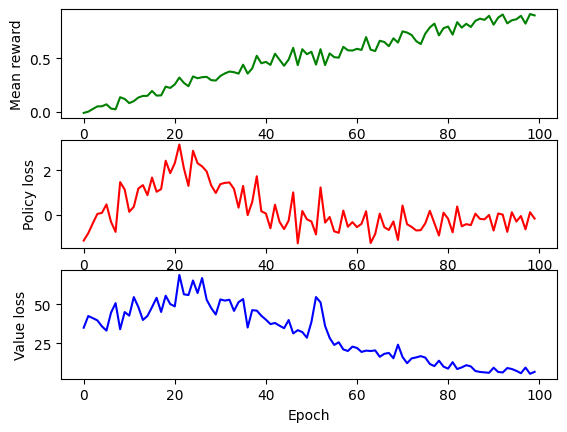

In [116]:
# training parameters
N = 32
T = 128
config = {'N': N, 'vis': 0}
epochs = 100
lr = 0.01
gamma = 0.95

# policy, environment and optimizer
pi = StochasticPolicyValue(state_dim=4)
train_env = PendulumEnv(config)
optim = torch.optim.SGD(pi.parameters(), lr=lr)

mean_rewards, p_losses, v_losses = np.zeros(epochs), np.zeros(epochs), np.zeros(epochs)  # logging
for epoch in range(epochs):
    tensor_s, tensor_a, tensor_r = sample_trajectories(train_env, pi, T)  # collect trajectories using current policy

    values = pi.value_estimates(tensor_s)  # estimate value function for all states
    logp = pi.log_prob(tensor_a, tensor_s[:T]).squeeze(2)  # compute log(pi(a_t | s_t))

    with torch.no_grad():  # no need for gradients when computing the advantages and value targets
        value_targets, advantage_estimates = compute_advantage_estimates(tensor_r, values, gamma, bootstrap=True)
        # value_targets, advantage_estimates = compute_gae(tensor_r, values, gamma, lambda_=0.99)

    L_pg = policy_gradient_loss_advantages(logp, advantage_estimates)  # compute the policy gradient loss
    L_v = value_loss(values[:T], value_targets)  # add the value loss
    total_loss = L_pg + L_v

    optim.zero_grad()
    total_loss.backward()  # backprop and gradient step
    optim.step()

    if epoch % 10 == 0:
        print('Epoch %d, mean reward: %.3f, value loss: %.3f' % (epoch, tensor_r.mean(), L_v.item()))
    mean_rewards[epoch] = tensor_r.mean()
    v_losses[epoch] = L_v.item()
    p_losses[epoch] = L_pg.item()

train_env.close()

plot_training(mean_rewards, p_losses, v_losses)

In [117]:
test_policy(pi, 256, {'N': 16, 'vis': VISUALIZE})

Environment ready


0.9998423982906388

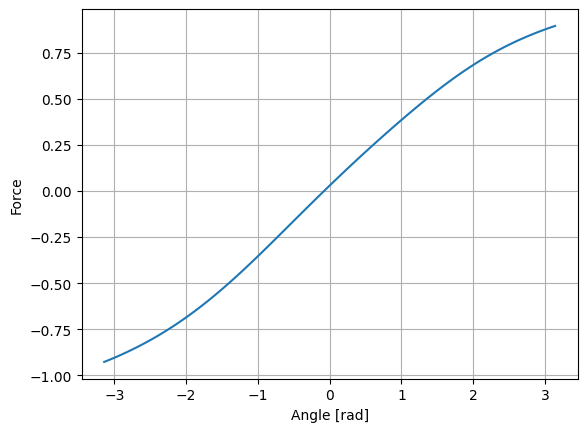

In [118]:
plot_action_vs_angle(pi)

# Task 4) Proximal policy optimization

The training using policy gradient estimate is inherently unstable and leads to catastrophic forgetting. The idea of the proximal policy optimization (PPO) algorithm is simple: Perform the policy gradient update, but do not change the policy behaviour too much. While gradient clipping would help remedy this problem, it operates in the parameter space, which does not guarantee proximity of the behaviour (even a small change in parameters $\theta$ can cause a large change in the action probabilities $\pi_\theta(a_t | s_t)$). The PPO algorithm uses clipping in the probability space instead.

First, let us define

$$
r_\theta(a_t | s_t) = \dfrac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{old}}(a_t | s_t)}
$$

which is simply the ratio of the 'new' probabilities $\pi_\theta(a_t | s_t)$ divided by the 'old' probabilities $\pi_{\theta_{old}}(a_t | s_t)$. The 'old' probabilities correspond to $\theta_{old}$, which are the policy parameters before the gradient update. The reason for these additional terms is that we will keep track of the 'old' parameters $\theta_{old}$ in order to enforce the proximity of the policy behaviour.
Note that

$$
\nabla_\theta r_\theta(a_t | s_t) |_{\theta=\theta_{old}} = \nabla_\theta \log(\pi_\theta(a_t | s_t)) |_{\theta=\theta_{old}}
$$

i.e. taking the gradient of this ratio is equivalent to taking the gradient of the policy log-probabilities when done at the initial parameters $\theta_{old}$. This gives rise to the following equivalent objective for the advantage-based policy gradient (here omitting the mean over all states and actions)

$$
J_{A}(a_t, s_t) =  \hat{A} \cdot r_\theta(a_t | s_t)
$$

where $\hat{A}$ is short for $\hat{A}(s_t, a_t)$ - the advantage estimate for state $s_t$ and action $a_t$. If we were to take the gradient of this objective, we would get exactly the same expression we used in the previous task. The PPO replaces this by the following surrogate objective

$$
L_{PPO}(a_t, s_t) = \min \left( \hat{A} \cdot r_\theta(a_t | s_t), \quad \hat{A} \cdot \text{clip}(r_\theta(a_t | s_t), 1-\epsilon, 1+\epsilon) \right)
$$

where $\epsilon \in (0, 1)$ is a hyperparameter known as the clipping ratio (typically $\epsilon = 0.2$). This objective essentially implements gradient clipping, but in the probability space. To be clear, this objective needs to be again averaged over all states and actions in the collected trajectories. The resulting policy gradient is

$$
\textcolor{red}{
\hat{g}_{PPO} = \frac{1}{N}\frac{1}{T} \sum_{i=1}^N \sum_{t=0}^{T-1} \nabla_\theta \min \left( \hat{A} \cdot r_\theta(a_t | s_t), \quad \hat{A} \cdot \text{clip}(r_\theta(a_t | s_t), 1-\epsilon, 1+\epsilon) \right)
}
$$

### The idea behind PPO

To understand, let us see what happens, when the advantage is positive $\hat{A} > 0$, i.e. we would like to increase the probability of the given action $a_t$. Then the objective reduces to

$$
\hat{A} \cdot \min \left(  r_\theta(a_t | s_t), \quad \text{clip}(r_\theta(a_t | s_t), 1-\epsilon, 1+\epsilon) \right)
$$

Now, if $r_\theta(a_t | s_t) \leq 1+\epsilon$, then the $\min()$ chooses the ratio itself and the result is the same as if we used the original objective. But if $r_\theta(a_t | s_t) > 1+\epsilon$, then the objective is stuck at the constant value of $\hat{A} \cdot (1+\epsilon)$ and therefore we get zero gradient. This means that the objective allows the policy to increase the probability of the action $a_t$ by at most $(1+\epsilon)$-times the 'old' probability.

Similarly, for a negative advantage $\hat{A} < 0$, we would like to reduce the probability of $a_t$. The PPO objective would be

$$
\hat{A} \cdot \max \left(  r_\theta(a_t | s_t), \quad \text{clip}(r_\theta(a_t | s_t), 1-\epsilon, 1+\epsilon) \right)
$$

If $r_\theta(a_t | s_t) \geq 1-\epsilon$, then the $\max$ chooses the ratio itself and nothing interesting happens. If $r_\theta(a_t | s_t) < 1-\epsilon$, however, then the objective is again stuck at a constant value of $\hat{A} \cdot (1-\epsilon)$ and the gradient is zero again. This does not let the probability of $a_t$ fall below $(1-\epsilon)$-times the 'old' probability.

So, essentially, the PPO objective will not allow the probabilities of the actions to change too much with respect to the 'old' policy that was used to sample the trajectories.

The following image illustrates the clipping objective for positive and negative advantages respectively.
<img src=https://miro.medium.com/v2/resize:fit:1400/1*RUEQ7RXzywlV63nZ0ldJUg.png width="600" align="center"/>


In [119]:
# TODO: implement ppo_loss in solution.py
from solution import ppo_loss

/Users/hella/Desktop/hw5-rl/solution.py:25: SyntaxWarning: invalid escape sequence '\s'
  """


Quick test for your implementation is below. The output should be: tensor(-0.8250)


In [120]:
test_p_ratios = torch.tensor([0.8, 1, 1, 0.6, 1.2, 1.4, 1.6, 0.2]).reshape((8, 1)).float()  # testing logp
test_advantage_estimates = torch.tensor([1, 2, 1, 0, 1, 1, 0, 2]).reshape((8, 1)).float()  # testing rewards
test_epsilon = 0.2

assert torch.allclose(ppo_loss(test_p_ratios, test_advantage_estimates, test_epsilon), torch.Tensor([-0.8250]), atol=1e-4), "incorrect output from ppo_loss"

Environment ready
Epoch 0, mean reward: 0.004, value loss: 26.078
Epoch 10, mean reward: 0.120, value loss: 25.560
Epoch 20, mean reward: 0.168, value loss: 24.215
Epoch 30, mean reward: 0.279, value loss: 25.320
Epoch 40, mean reward: 0.374, value loss: 17.131
Epoch 50, mean reward: 0.504, value loss: 9.759
Epoch 60, mean reward: 0.537, value loss: 8.689
Epoch 70, mean reward: 0.700, value loss: 5.486
Epoch 80, mean reward: 0.838, value loss: 3.027
Epoch 90, mean reward: 0.937, value loss: 1.059
Epoch 100, mean reward: 0.978, value loss: 0.111
Epoch 110, mean reward: 0.991, value loss: 0.022
Epoch 120, mean reward: 0.996, value loss: 0.015
Epoch 130, mean reward: 0.996, value loss: 0.017
Epoch 140, mean reward: 0.998, value loss: 0.002
Epoch 150, mean reward: 0.998, value loss: 0.003
Epoch 160, mean reward: 0.998, value loss: 0.002
Epoch 170, mean reward: 0.998, value loss: 0.002
Epoch 180, mean reward: 0.997, value loss: 0.031
Epoch 190, mean reward: 0.998, value loss: 0.008
Epoch 20

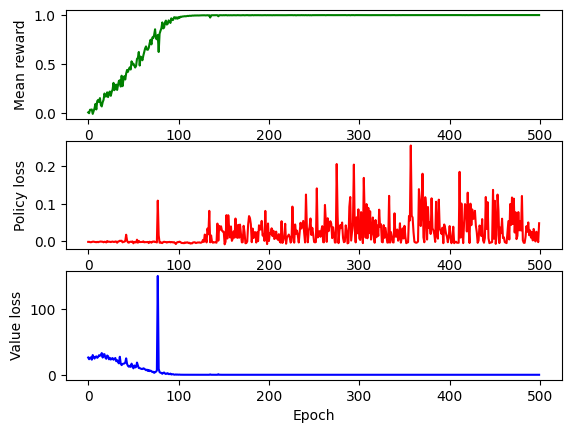

In [121]:
# training parameters
N = 32
T = 128
config = {'N': N, 'vis': 0}
epochs = 500
lr = 0.01
gamma = 0.95
epsilon = 0.2

sgd_iters = 5

# policy, environment and optimizer
pi = StochasticPolicyValue(state_dim=4)
train_env = PendulumEnv(config)
optim = torch.optim.SGD(pi.parameters(), lr=lr)

mean_rewards, p_losses, v_losses = np.zeros(epochs), np.zeros(epochs), np.zeros(epochs)  # for logging mean rewards over epochs
for epoch in range(epochs):
    tensor_s, tensor_a, tensor_r = sample_trajectories(train_env, pi, T)  # collect trajectories using current policy

    with torch.no_grad():  # compute the old probabilities
        logp_old = pi.log_prob(tensor_a, tensor_s[:T]).squeeze(2)  # compute log(pi(a_t | s_t))

    for i in range(sgd_iters):  # we can even do multiple gradient steps
        values = pi.value_estimates(tensor_s)  # estimate value function for all states
        logp = pi.log_prob(tensor_a, tensor_s[:T]).squeeze(2)  # compute log(pi(a_t | s_t))

        with torch.no_grad():  # no need for gradients when computing the advantages and value targets
            # value_targets, advantage_estimates = compute_advantage_estimates(tensor_r, values, gamma, bootstrap=True)
            value_targets, advantage_estimates = compute_gae(tensor_r, values, gamma, lambda_=0.97)
            advantage_estimates = (advantage_estimates - advantage_estimates.mean()) / advantage_estimates.std()  # normalize advantages

        L_v = value_loss(values[:T], value_targets)  # add the value loss

        p_ratios = torch.exp(logp - logp_old)  # compute the ratios r_\theta(a_t | s_t)
        L_ppo = ppo_loss(p_ratios, advantage_estimates, epsilon=epsilon)  # compute the policy gradient loss
        total_loss = L_v + L_ppo

        optim.zero_grad()
        total_loss.backward()  # backprop and gradient step
        optim.step()

    if epoch % 10 == 0:
        print('Epoch %d, mean reward: %.3f, value loss: %.3f' % (epoch, tensor_r.mean(), L_v.item()))
    mean_rewards[epoch] = tensor_r.mean()
    v_losses[epoch] = L_v.item()
    p_losses[epoch] = L_ppo.item()

train_env.close()

plot_training(mean_rewards, p_losses, v_losses)

In [122]:
test_policy(pi, 512, {'N': 16, 'vis': VISUALIZE})

Environment ready


0.9998652316935477

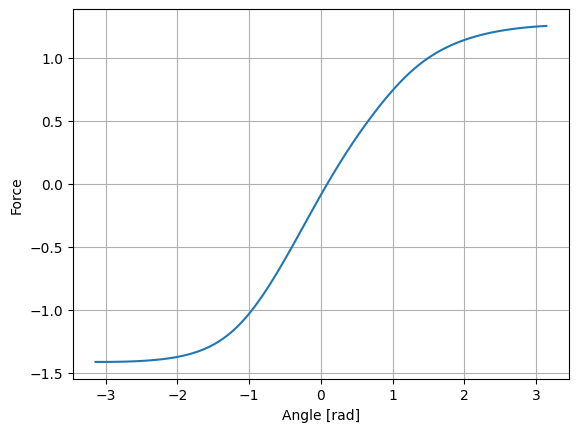

In [123]:
plot_action_vs_angle(pi)

The end!


## Suplementary material

Reinforcement learning explanation https://spinningup.openai.com/en/latest/index.html
Physical simulator MuJoCo https://mujoco.readthedocs.io/en/latest/computation/index.html
